# Backpropagation
## Instructions

In this assignment, you will train a neural network to draw a curve.
The curve takes one input variable, the amount travelled along the curve from 0 to 1, and returns 2 outputs, the 2D coordinates of the position of points on the curve.

To help capture the complexity of the curve, we shall use two hidden layers in our network with 6 and 7 neurons respectively.

![Neural network with 2 hidden layers. There is 1 nodes in the zeroth layer, 6 in the first, 7 in the second, and 2 in the third.](readonly/bigNet.png "The structure of the network we will consider in this assignment.")

You will be asked to complete functions that calculate the Jacobian of the cost function, with respect to the weights and biases of the network. Your code will form part of a stochastic steepest descent algorithm that will train your network.

### Matrices in Python
Recall from assignments in the previous course in this specialisation that matrices can be multiplied together in two ways.

Element wise: when two matrices have the same dimensions, matrix elements in the same position in each matrix are multiplied together
In python this uses the '$*$' operator.
```python
A = B * C
```

Matrix multiplication: when the number of columns in the first matrix is the same as the number of rows in the second.
In python this uses the '$@$' operator
```python
A = B @ C
```

This assignment will not test which ones to use where, but it will use both in the starter code presented to you.
There is no need to change these or worry about their specifics.

### How to submit
To complete the assignment, edit the code in the cells below where you are told to do so.
Once you are finished and happy with it, press the **Submit Assignment** button at the top of this worksheet.
Test your code using the cells at the bottom of the notebook before you submit.

Please don't change any of the function names, as these will be checked by the grading script.

## Feed forward

In the following cell, we will define functions to set up our neural network.
Namely an activation function, $\sigma(z)$, it's derivative, $\sigma'(z)$, a function to initialise weights and biases, and a function that calculates each activation of the network using feed-forward.

Recall the feed-forward equations,
$$ \mathbf{a}^{(n)} = \sigma(\mathbf{z}^{(n)}) $$
$$ \mathbf{z}^{(n)} = \mathbf{W}^{(n)}\mathbf{a}^{(n-1)} + \mathbf{b}^{(n)} $$

In this worksheet we will use the *logistic function* as our activation function, rather than the more familiar $\tanh$.
$$ \sigma(\mathbf{z}) = \frac{1}{1 + \exp(-\mathbf{z})} $$

There is no need to edit the following cells.
They do not form part of the assessment.
You may wish to study how it works though.

**Run the following cells before continuing.**

In [1]:
%run "readonly/BackpropModule.ipynb"

Populating the interactive namespace from numpy and matplotlib


In [2]:
# PACKAGE
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# PACKAGE
# First load the worksheet dependencies.
# Here is the activation function and its derivative.
sigma = lambda z : 1 / (1 + np.exp(-z))
d_sigma = lambda z : np.cosh(z/2)**(-2) / 4

# This function initialises the network with it's structure, it also resets any training already done.
def reset_network (n1 = 6, n2 = 7, random=np.random) :
    global W1, W2, W3, b1, b2, b3
    W1 = random.randn(n1, 1) / 2
    W2 = random.randn(n2, n1) / 2
    W3 = random.randn(2, n2) / 2
    b1 = random.randn(n1, 1) / 2
    b2 = random.randn(n2, 1) / 2
    b3 = random.randn(2, 1) / 2

# This function feeds forward each activation to the next layer. It returns all weighted sums and activations.
def network_function(a0) :
    z1 = W1 @ a0 + b1
    a1 = sigma(z1)
    z2 = W2 @ a1 + b2
    a2 = sigma(z2)
    z3 = W3 @ a2 + b3
    a3 = sigma(z3)
    return a0, z1, a1, z2, a2, z3, a3

# This is the cost function of a neural network with respect to a training set.
# np.linalg.norm() returns the norm of a vector or a matrix i.e., magnitude 
# for an array a, a[-1] returns the last element
def cost(x, y) :
    return np.linalg.norm(network_function(x)[-1] - y)**2 / x.size

In [4]:
random.randn(6,7)

array([[ 0.4475808 ,  0.1795288 ,  0.39700379,  2.70842542,  0.00645138,
        -2.35817903,  1.3582444 ],
       [-0.51955828, -0.70632571, -1.27813974, -0.71849212, -1.02762344,
         0.9287895 ,  1.19021157],
       [ 1.48226732, -1.09547117, -1.18708715,  0.1733081 ,  0.16450515,
        -1.12130815,  1.86146788],
       [ 1.4297469 , -0.53949549,  1.38919943, -1.46953025, -0.61154951,
         1.15617121,  0.18449198],
       [ 0.32500175, -0.14636061,  0.90381393,  0.30927911,  0.91534364,
        -1.1019672 , -0.7330537 ],
       [-0.25670802,  0.39544497,  0.93993106, -0.85366705, -0.61822602,
        -0.90176557, -0.33958527]])

## Backpropagation

In the next cells, you will be asked to complete functions for the Jacobian of the cost function with respect to the weights and biases.
We will start with layer 3, which is the easiest, and work backwards through the layers.

We'll define our Jacobians as,
$$ \mathbf{J}_{\mathbf{W}^{(3)}} = \frac{\partial C}{\partial \mathbf{W}^{(3)}} $$
$$ \mathbf{J}_{\mathbf{b}^{(3)}} = \frac{\partial C}{\partial \mathbf{b}^{(3)}} $$
etc., where $C$ is the average cost function over the training set. i.e.,
$$ C = \frac{1}{N}\sum_k C_k $$
You calculated the following in the practice quizzes,
$$ \frac{\partial C}{\partial \mathbf{W}^{(3)}} =
   \frac{\partial C}{\partial \mathbf{a}^{(3)}}
   \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{z}^{(3)}}
   \frac{\partial \mathbf{z}^{(3)}}{\partial \mathbf{W}^{(3)}}
   ,$$
for the weight, and similarly for the bias,
$$ \frac{\partial C}{\partial \mathbf{b}^{(3)}} =
   \frac{\partial C}{\partial \mathbf{a}^{(3)}}
   \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{z}^{(3)}}
   \frac{\partial \mathbf{z}^{(3)}}{\partial \mathbf{b}^{(3)}}
   .$$
With the partial derivatives taking the form,
$$ \frac{\partial C}{\partial \mathbf{a}^{(3)}} = 2(\mathbf{a}^{(3)} - \mathbf{y}) $$
$$ \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{z}^{(3)}} = \sigma'({z}^{(3)})$$
$$ \frac{\partial \mathbf{z}^{(3)}}{\partial \mathbf{W}^{(3)}} = \mathbf{a}^{(2)}$$
$$ \frac{\partial \mathbf{z}^{(3)}}{\partial \mathbf{b}^{(3)}} = 1$$

We'll do the J_W3 ($\mathbf{J}_{\mathbf{W}^{(3)}}$) function for you, so you can see how it works.
You should then be able to adapt the J_b3 function, with help, yourself.

In [5]:
# GRADED FUNCTION

# Jacobian for the third layer weights. There is no need to edit this function.
def J_W3 (x, y) :
    # First get all the activations and weighted sums at each layer of the network.
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    # We'll use the variable J to store parts of our result as we go along, updating it in each line.
    # Firstly, we calculate dC/da3, using the expressions above.
    J = 2 * (a3 - y)
    # Next multiply the result we've calculated by the derivative of sigma, evaluated at z3.
    J = J * d_sigma(z3)
    # Then we take the dot product (along the axis that holds the training examples) with the final partial derivative,
    # i.e. dz3/dW3 = a2
    # and divide by the number of training examples, for the average over all training examples.
    J = J @ a2.T / x.size
    # Finally return the result out of the function.
    return J

# In this function, you will implement the jacobian for the bias.
# As you will see from the partial derivatives, only the last partial derivative is different.
# The first two partial derivatives are the same as previously.
# ===YOU SHOULD EDIT THIS FUNCTION===
def J_b3 (x, y) :
    # As last time, we'll first set up the activations.
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    # Next you should implement the first two partial derivatives of the Jacobian.
    # ===COPY TWO LINES FROM THE PREVIOUS FUNCTION TO SET UP THE FIRST TWO JACOBIAN TERMS===
    J = 2 * (a3 - y)
    # Next multiply the result we've calculated by the derivative of sigma, evaluated at z3.
    J = J * d_sigma(z3) * 1
    # For the final line, we don't need to multiply by dz3/db3, because that is multiplying by 1.
    # We still need to sum over all training examples however.
    # There is no need to edit this line.
    J = np.sum(J, axis=1, keepdims=True) / x.size
    return J

We'll next do the Jacobian for the Layer 2. The partial derivatives for this are,
$$ \frac{\partial C}{\partial \mathbf{W}^{(2)}} =
   \frac{\partial C}{\partial \mathbf{a}^{(3)}}
   \left(
   \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{a}^{(2)}}
   \right)
   \frac{\partial \mathbf{a}^{(2)}}{\partial \mathbf{z}^{(2)}}
   \frac{\partial \mathbf{z}^{(2)}}{\partial \mathbf{W}^{(2)}}
   ,$$
$$ \frac{\partial C}{\partial \mathbf{b}^{(2)}} =
   \frac{\partial C}{\partial \mathbf{a}^{(3)}}
   \left(
   \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{a}^{(2)}}
   \right)
   \frac{\partial \mathbf{a}^{(2)}}{\partial \mathbf{z}^{(2)}}
   \frac{\partial \mathbf{z}^{(2)}}{\partial \mathbf{b}^{(2)}}
   .$$
This is very similar to the previous layer, with two exceptions:
* There is a new partial derivative, in parentheses, $\frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{a}^{(2)}}$
* The terms after the parentheses are now one layer lower.

Recall the new partial derivative takes the following form,
$$ \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{a}^{(2)}} =
   \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{z}^{(3)}}
   \frac{\partial \mathbf{z}^{(3)}}{\partial \mathbf{a}^{(2)}} =
   \sigma'(\mathbf{z}^{(3)})
   \mathbf{W}^{(3)}
$$

To show how this changes things, we will implement the Jacobian for the weight again and ask you to implement it for the bias.

In [6]:
# GRADED FUNCTION

# Compare this function to J_W3 to see how it changes.
# There is no need to edit this function.
def J_W2 (x, y) :
    #The first two lines are identical to in J_W3.
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)    
    J = 2 * (a3 - y)
    # the next two lines implement da3/da2, first σ' and then W3.
    J = J * d_sigma(z3)
    J = (J.T @ W3).T
    # then the final lines are the same as in J_W3 but with the layer number bumped down.
    J = J * d_sigma(z2)
    J = J @ a1.T / x.size
    return J

# As previously, fill in all the incomplete lines.
# ===YOU SHOULD EDIT THIS FUNCTION===
def J_b2 (x, y) :
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    J = 2 * (a3 - y)
    J = J * d_sigma(z3)
    J = (J.T @ W3).T
    J = J * d_sigma(z2)
    J = np.sum(J, axis=1, keepdims=True) / x.size
    return J

Layer 1 is very similar to Layer 2, but with an addition partial derivative term.
$$ \frac{\partial C}{\partial \mathbf{W}^{(1)}} =
   \frac{\partial C}{\partial \mathbf{a}^{(3)}}
   \left(
   \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{a}^{(2)}}
   \frac{\partial \mathbf{a}^{(2)}}{\partial \mathbf{a}^{(1)}}
   \right)
   \frac{\partial \mathbf{a}^{(1)}}{\partial \mathbf{z}^{(1)}}
   \frac{\partial \mathbf{z}^{(1)}}{\partial \mathbf{W}^{(1)}}
   ,$$
$$ \frac{\partial C}{\partial \mathbf{b}^{(1)}} =
   \frac{\partial C}{\partial \mathbf{a}^{(3)}}
   \left(
   \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{a}^{(2)}}
   \frac{\partial \mathbf{a}^{(2)}}{\partial \mathbf{a}^{(1)}}
   \right)
   \frac{\partial \mathbf{a}^{(1)}}{\partial \mathbf{z}^{(1)}}
   \frac{\partial \mathbf{z}^{(1)}}{\partial \mathbf{b}^{(1)}}
   .$$
You should be able to adapt lines from the previous cells to complete **both** the weight and bias Jacobian.

In [7]:
# GRADED FUNCTION

# Fill in all incomplete lines.
# ===YOU SHOULD EDIT THIS FUNCTION===
def J_W1 (x, y) :
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    J = 2 * (a3 - y)
    # the next two lines implement da3/da2, first σ' and then W3.
    J = J * d_sigma(z3)
    J = (J.T @ W3).T
    # the next two lines implement da2/da1, first σ' and then W2.
    J = J * d_sigma(z2)
    J = (J.T @ W2).T
    
    J = J * d_sigma(z1)
    J = J @ a0.T / x.size
    return J

# Fill in all incomplete lines.
# ===YOU SHOULD EDIT THIS FUNCTION===
def J_b1 (x, y) :
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    J = 2 * (a3 - y)
    # the next two lines implement da3/da2, first σ' and then W3.
    J = J * d_sigma(z3)
    J = (J.T @ W3).T
    # the next two lines implement da2/da1, first σ' and then W2.
    J = J * d_sigma(z2)
    J = (J.T @ W2).T
    
    J = J * d_sigma(z1)
    J = np.sum(J, axis=1, keepdims=True) / x.size
    return J

## Test your code before submission
To test the code you've written above, run all previous cells (select each cell, then press the play button [ ▶| ] or press shift-enter).
You can then use the code below to test out your function.
You don't need to submit these cells; you can edit and run them as much as you like.

First, we generate training data, and generate a network with randomly assigned weights and biases.

In [8]:
x, y = training_data()
reset_network()

Next, if you've implemented the assignment correctly, the following code will iterate through a steepest descent algorithm using the Jacobians you have calculated.
The function will plot the training data (in green), and your neural network solutions in pink for each iteration, and orange for the last output.

It takes about 50,000 iterations to train this network.
We can split this up though - **10,000 iterations should take about a minute to run**.
Run the line below as many times as you like.

<IPython.core.display.Javascript object>


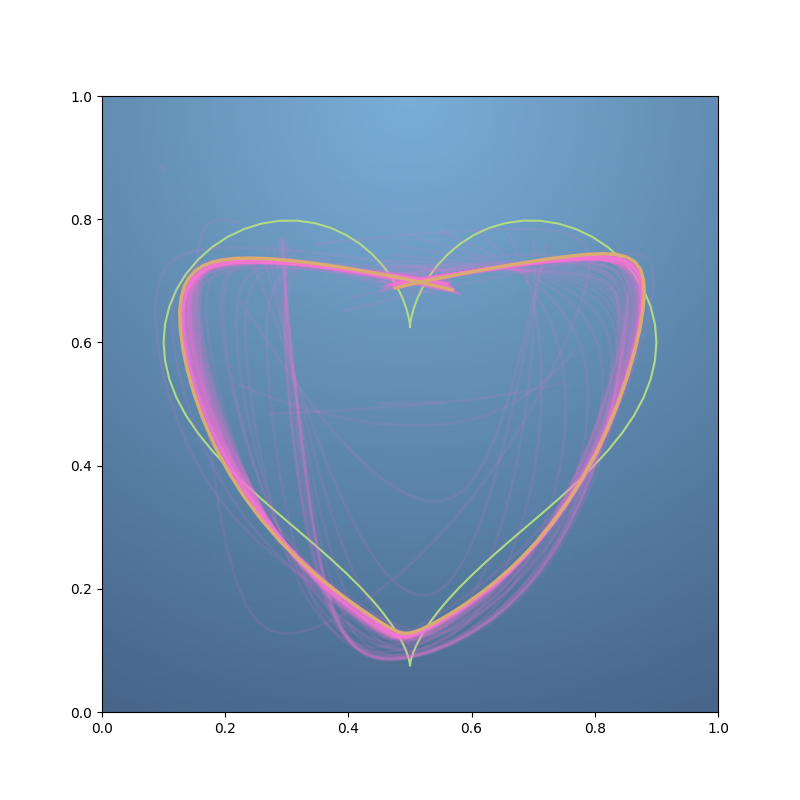

In [9]:
plot_training(x, y, iterations=10000, aggression=7, noise=1)

If you wish, you can change parameters of the steepest descent algorithm (We'll go into more details in future exercises), but you can change how many iterations are plotted, how agressive the step down the Jacobian is, and how much noise to add.

You can also edit the parameters of the neural network, i.e. to give it different amounts of neurons in the hidden layers by calling,
```python
reset_network(n1, n2)
```

Play around with the parameters, and save your favourite result for the discussion prompt - *I ❤️ backpropagation*.